# Categorical Regression

In this example, we will use the categorical family to model outcomes with more than two categories. The examples in this were constructed by Tomás Capretto, and assembled into this example by Tyler James Burch (@tjburch on GitHub).

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
SEED = 1234

In [2]:
az.style.use("arviz-darkgrid")

When modeling binary outcomes with Bambi, the Bernoulli family is used. The multivariate generalization of the Bernoulli family is the Categorical family, and with it, we can model an arbitrary number of outcome categories. 

## Example with toy data

To start, we will create a toy dataset with three classes.

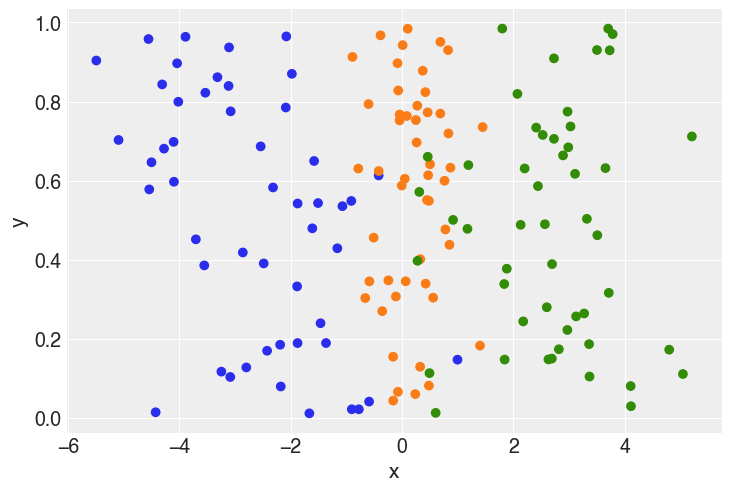

In [3]:
rng = np.random.default_rng(SEED)
x = np.hstack([rng.normal(m, s, size=50) for m, s in zip([-2.5, 0, 2.5], [1.2, 0.5, 1.2])])
y = np.array(["A"] * 50 + ["B"] * 50 + ["C"] * 50)

colors = ["C0"] * 50 + ["C1"] * 50 + ["C2"] * 50
plt.scatter(x, np.random.uniform(size=150), color=colors)
plt.xlabel("x")
plt.ylabel("y");

Here we have 3 classes, generated from three normal distributions: $N(-2.5, 1.2)$, $N(0, 0.5)$, and $N(2.5, 1.2)$. Creating a model to fit these distributions,

In [4]:
data = pd.DataFrame({"y": y, "x": x})
model = bmb.Model("y ~ x", data, family="categorical")
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.


Note that we pass the `family="categorical"` argument to Bambi's `Model` method in order to call the categorical family. Here, the response variable are strings ("A", "B", "C"), however they can also be `pd.Categorical` objects.

Next we will use posterior predictions to visualize the mean class probability across the $x$ spectrum.

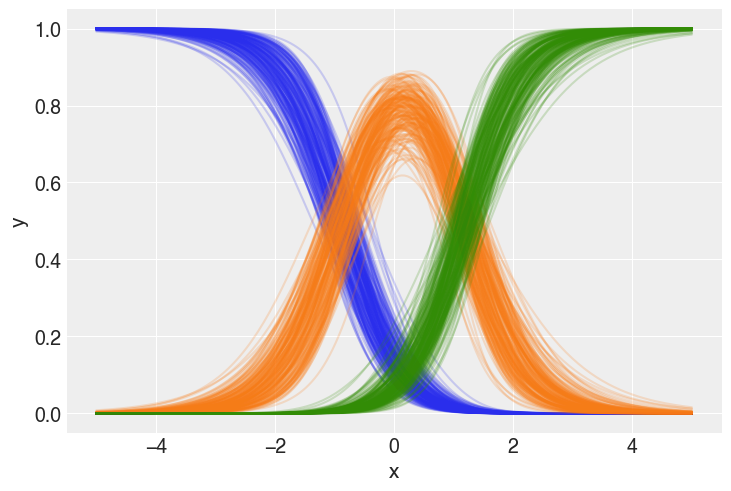

In [5]:
x_new = np.linspace(-5, 5, num=200)
model.predict(idata, data=pd.DataFrame({"x": x_new}))
p = idata.posterior["y_mean"].sel(draw=slice(0, None, 10))

for j, g in enumerate("ABC"):
   plt.plot(x_new, p.sel({"y_mean_coord":g}).stack(samples=("chain", "draw")), color=f"C{j}", alpha=0.2)

plt.xlabel("x")
plt.ylabel("y");

Here, we can notice that the probability phases betweeen classes from left to right. At all points across $x$, sum of the class probabilities is 1, since in our generative model, it must be one of these three outcomes.  

## The iris dataset

Next, we will look at the classic "iris" dataset, which contains samples from 3 different species of iris plants. Using properties of the plant, we will try to model its species.

In [6]:
iris = sns.load_dataset('iris')
iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa


The dataset includes four different properties of the plants: it's sepal length, sepal width, petal length, and petal width. There are 3 different class possibilities: setosa, versicolor, and virginica.

/Users/tburch/Documents/github/bambi/bambi_dev/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


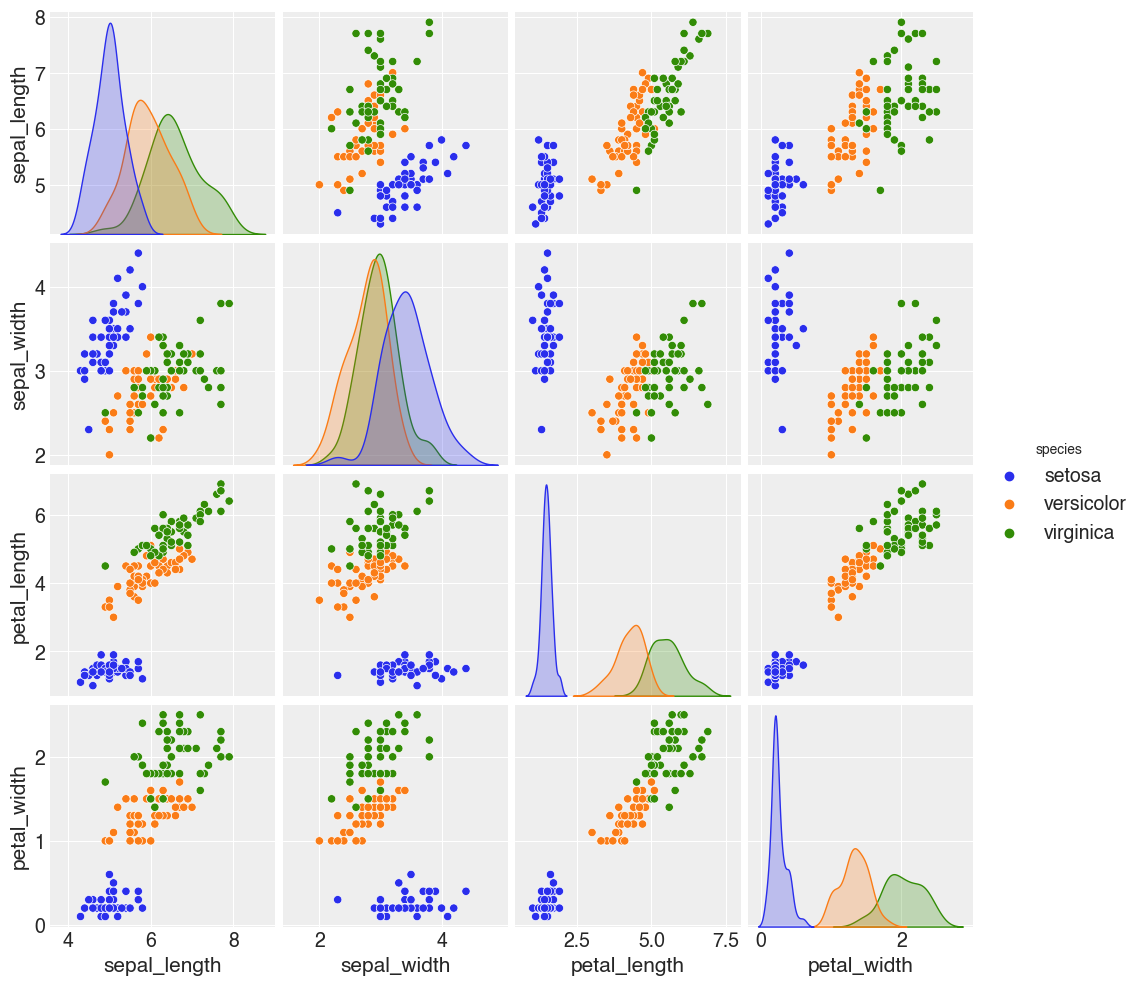

In [7]:
sns.pairplot(iris, hue='species');

We can see the three species have several distinct characteristics, which our linear model can capture to distinguish between them.

In [8]:
model = bmb.Model(
    "species ~ sepal_length + sepal_width + petal_length + petal_width", 
    iris, 
    family="categorical",
)
idata = model.fit()
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [petal_width, petal_length, sepal_width, sepal_length, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[versicolor],-6.562,7.612,-19.961,8.753,0.227,0.170,1129.0,1188.0,1.0
Intercept[virginica],-22.382,9.247,-39.683,-5.348,0.246,0.175,1414.0,1299.0,1.0
sepal_length[versicolor],3.020,1.706,-0.110,6.175,0.059,0.042,826.0,999.0,1.0
sepal_length[virginica],2.216,1.754,-1.292,5.364,0.063,0.044,781.0,1090.0,1.0
sepal_width[versicolor],-4.652,1.962,-8.409,-1.214,0.068,0.048,807.0,977.0,1.0
sepal_width[virginica],-6.483,2.360,-10.613,-1.830,0.083,0.059,793.0,1024.0,1.0
petal_length[versicolor],1.089,0.867,-0.399,2.724,0.029,0.021,885.0,1300.0,1.0
petal_length[virginica],4.018,1.004,2.181,5.882,0.033,0.023,921.0,920.0,1.0
petal_width[versicolor],1.846,2.017,-2.088,5.448,0.069,0.053,869.0,1125.0,1.0
petal_width[virginica],8.941,2.210,4.920,13.073,0.080,0.057,760.0,903.0,1.0


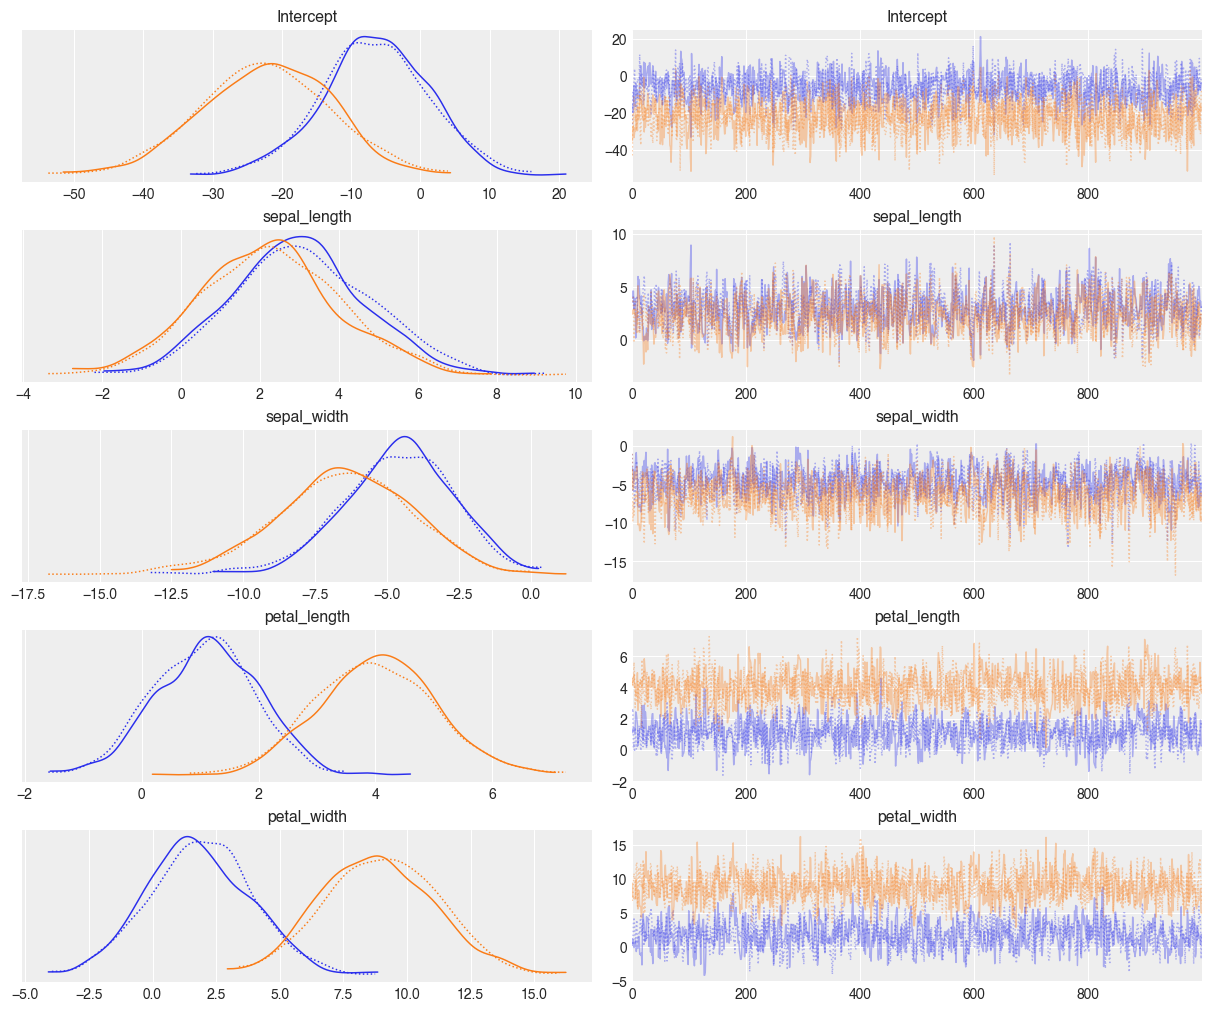

In [9]:
az.plot_trace(idata);


We can see that this has fit quite nicely. You'll notice there are $n-1$ parameters to fit, where $n$ is the number of categories. In the minimal binary case, recall there's only one parameter set, since it models probability $p$ of being in a class, and probability $1-p$ of being in the other class. Using the categorical distribution, this extends, so we have $p_1$ for class 1, $p_2$ for class 2, and $1-(p_1+p_2)$ for the final class.

## Using numerical and categorical predictors

Next we will look at an example from chapter 8 of Alan Agresti's _Categorical Data Analysis_, looking at the primary food choice for 64 alligators caught in Lake George, Florida. We will use their length (a continuous variable) and sex (a categorical variable) as predictors to model their food choice.

First, reproducing the dataset,

In [10]:
length = [
    1.3, 1.32, 1.32, 1.4, 1.42, 1.42, 1.47, 1.47, 1.5, 1.52, 1.63, 1.65, 1.65, 1.65, 1.65,
    1.68, 1.7, 1.73, 1.78, 1.78, 1.8, 1.85, 1.93, 1.93, 1.98, 2.03, 2.03, 2.31, 2.36, 2.46,
    3.25, 3.28, 3.33, 3.56, 3.58, 3.66, 3.68, 3.71, 3.89, 1.24, 1.3, 1.45, 1.45, 1.55, 1.6, 
    1.6, 1.65, 1.78, 1.78, 1.8, 1.88, 2.16, 2.26, 2.31, 2.36, 2.39, 2.41, 2.44, 2.56, 2.67, 
    2.72, 2.79, 2.84
]
choice = [
    "I", "F", "F", "F", "I", "F", "I", "F", "I", "I", "I", "O", "O", "I", "F", "F", 
    "I", "O", "F", "O", "F", "F", "I", "F", "I", "F", "F", "F", "F", "F", "O", "O", 
    "F", "F", "F", "F", "O", "F", "F", "I", "I", "I", "O", "I", "I", "I", "F", "I", 
    "O", "I", "I", "F", "F", "F", "F", "F", "F", "F", "O", "F", "I", "F", "F"
]

sex = ["Male"] * 32 + ["Female"] * 31
data = pd.DataFrame({"choice": choice, "length": length, "sex": sex})
data["choice"]  = pd.Categorical(
    data["choice"].map({"I": "Invertebrates", "F": "Fish", "O": "Other"}), 
    ["Other", "Invertebrates", "Fish"], 
    ordered=True
)
data.head(3)

,choice,length,sex
0,Invertebrates,1.30,Male
1,Fish,1.32,Male
2,Fish,1.32,Male


Next, constructing the model,

In [11]:
model = bmb.Model("choice ~ length + sex", data, family="categorical")
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sex, length, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


We can then look at how the food choices vary by length for both male and female alligators.

/var/folders/6_/4vqvy7vn7kd0q5_ckhj7prfc0000gn/T/ipykernel_3881/2612338171.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(left=0.05, right=0.975, bottom=0.075, top=0.85)


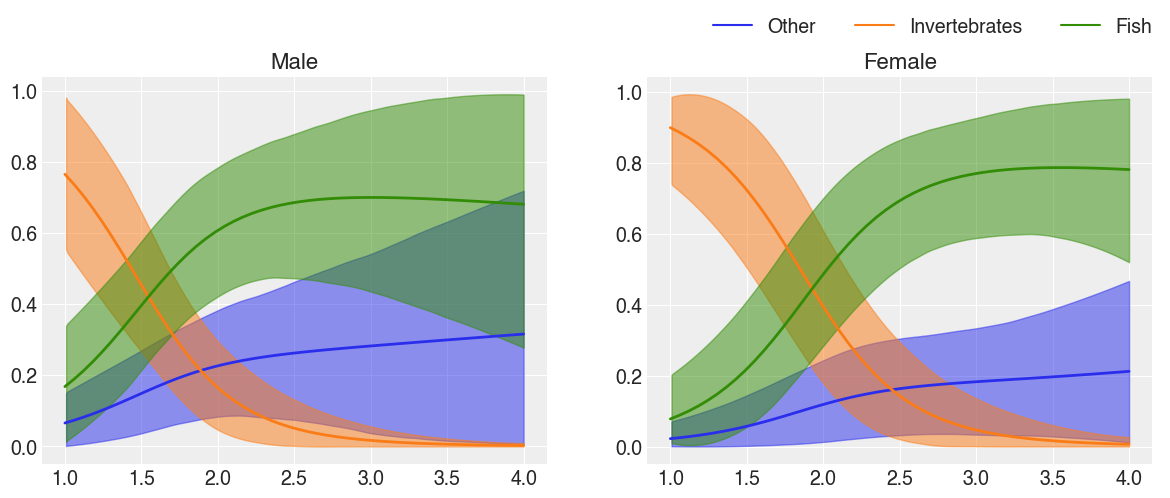

In [12]:
new_length = np.linspace(1, 4)
new_data = pd.DataFrame({"length": np.tile(new_length, 2), "sex": ["Male"] * 50 + ["Female"] * 50})
model.predict(idata, data=new_data)
p = idata.posterior["choice_mean"]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
choices = ["Other", "Invertebrates", "Fish"]

for j, choice in enumerate(choices):
   males = p.sel({"choice_mean_coord":choice, "choice_obs":slice(0, 49)})
   females = p.sel({"choice_mean_coord":choice, "choice_obs":slice(50, 100)})
   axes[0].plot(new_length, males.mean(("chain", "draw")), color=f"C{j}", lw=2)
   axes[1].plot(new_length, females.mean(("chain", "draw")), color=f"C{j}", lw=2)
   az.plot_hdi(new_length, males, color=f"C{j}", ax=axes[0])
   az.plot_hdi(new_length, females, color=f"C{j}", ax=axes[1])

axes[0].set_title("Male")
axes[1].set_title("Female")

handles = [Line2D([], [], color=f"C{j}", label=choice) for j, choice in enumerate(choices)]
fig.subplots_adjust(left=0.05, right=0.975, bottom=0.075, top=0.85)

fig.legend(
   handles,
   choices,
   loc="center right",
   ncol=3,
   bbox_to_anchor=(0.99, 0.95),
   bbox_transform=fig.transFigure
);

Here we can see that the larger male and female alligators are, the less of a taste they have for invertebrates, and far prefer fish. Additionally, males seem to have a higher propensity to consume "other" foods compared to females at any size. Of note, the posterior means predicted by Bambi contain information about all $n$ categories (despite having only $n-1$ coefficients), so we can directly construct this plot, rather than manually calculating $1-(p_1+p_2)$ for the third class.

Last, we can make a posterior predictive plot,

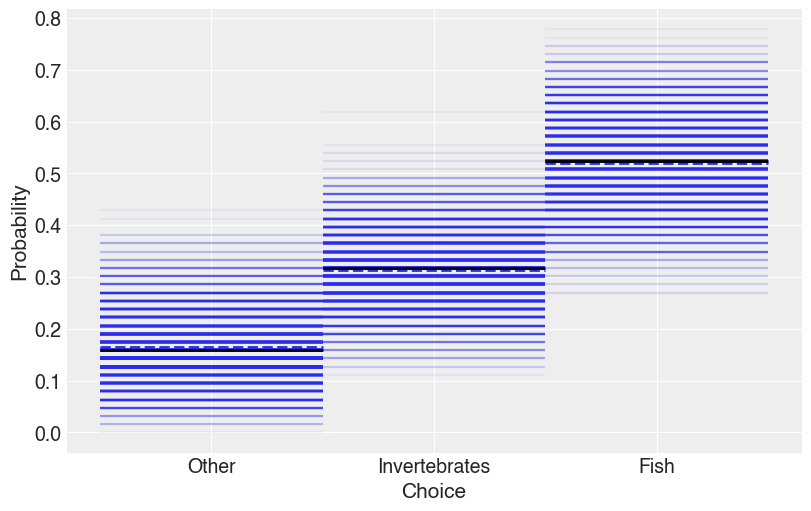

In [13]:
model.predict(idata, kind="pps")

draws = np.prod(idata.posterior_predictive["choice"].shape[:2])
choices = ["Other", "Invertebrates", "Fish"]

pps = idata.posterior_predictive["choice"].values.reshape(draws, 63)

y = np.zeros((draws, len(choices)))
for i in range(draws):
    for j in range(len(choices)):
        y[i, j] = np.sum(pps[i] == j)

y = y / y.sum(axis=1)[:, None]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(choices))

for i in range(draws):
    ax.hlines(y[i], xmin=x - 0.5, xmax=x + 0.5, alpha=0.05)
ax.hlines(y.mean(0), xmin=x - 0.5, xmax=x + 0.5, color="C0", lw=2, ls="--")

true_counts = data["choice"].value_counts().sort_index()
true_counts = true_counts / true_counts.sum()
ax.hlines(true_counts, xmin=x - 0.5, xmax=x + 0.5, color="black", lw=2)

ax.set_xticks(x)
ax.set_xticklabels(choices)
ax.set_xlabel("Choice")
ax.set_ylabel("Probability");

which depicts posterior predicted probability for each possible food choice for an alligator, which reinforces fish being the most likely food choice, followed by invertebrates.

### References

Agresti, A. (2013) Categorical Data Analysis. 3rd Edition, John Wiley & Sons Inc., Hoboken.